# Exploração de Modelos - Análise de Recomendações

Este notebook permite explorar e validar as recomendações geradas pelos modelos treinados.

## O que vamos fazer?

1. **Carregar um modelo treinado** - Usar um checkpoint salvo durante o treinamento
2. **Simular sessões de usuários** - Definir quais anúncios um usuário já viu
3. **Gerar recomendações** - Ver o que o modelo recomendaria para esse usuário
4. **Analisar as características** - Comparar anúncios vistos vs recomendados
5. **Validar se fazem sentido** - Verificar se as recomendações são coerentes

## Por que isso é importante?

Métricas como Recall@10 e MRR mostram **quantitativamente** se o modelo é bom.
Mas essa análise qualitativa mostra **se as recomendações fazem sentido** do ponto de vista de negócio.

## 1. Setup

Configuração inicial do ambiente. Esta célula:
- Detecta automaticamente o diretório do projeto
- Configura o Python para encontrar o código
- Habilita autoreload (mudanças no código são aplicadas automaticamente)

In [26]:
import sys
import os
from pathlib import Path

# Garantir que estamos no diretório do projeto
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
os.chdir(project_root)
sys.path.insert(0, str(project_root))

print(f"Diretório do projeto: {project_root}")

# Autoreload para pegar mudanças no código
%load_ext autoreload
%autoreload 2

from src.exploration.model_explorer import ModelExplorer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use('ggplot')

print("✓ Ambiente configurado com sucesso!")

Diretório do projeto: /home/hygo2025/Development/projects/fermi
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Ambiente configurado com sucesso!


## 2. Carregar Modelo

Aqui carregamos um modelo treinado a partir do checkpoint salvo.

### O que é carregado?
- **Parâmetros do modelo** (pesos das redes neurais)
- **Configuração** (hiperparâmetros usados no treinamento)
- **Dataset** (mapeamento de IDs para reconstruir o modelo)

### Como escolher o checkpoint?
- Use `ls outputs/saved/` para ver os modelos disponíveis
- Cada arquivo tem o formato: `MODELO-Data_Hora.pth`
- Escolha o modelo que teve melhor desempenho nos experimentos

In [27]:
# Caminho para o checkpoint do modelo
# AJUSTE: Coloque o caminho do seu modelo aqui
model_path = 'outputs/saved/GRU4Rec-Dec-16-2025_15-31-14.pth'

# Criar explorador
print("Carregando modelo...\n")
explorer = ModelExplorer(model_path)

print(f"\n✓ Pronto! O modelo está carregado e pode gerar recomendações.")
print(f"  Total de anúncios no dataset: {explorer.dataset.item_num}")

Carregando modelo...


Carregando modelo de: outputs/saved/GRU4Rec-Dec-16-2025_15-31-14.pth
Dataset carregado: realestate_slice1
✓ Modelo GRU4Rec carregado com sucesso!
  Items: 23502
  Device: cuda

✓ Pronto! O modelo está carregado e pode gerar recomendações.
  Total de anúncios no dataset: 23502


/home/hygo2025/Development/projects/fermi/.venv/lib/python3.9/site-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/home/hygo2025/Development/projects/fermi/.venv/lib/python3.9/site-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the 

## 3. Carregar Features dos Anúncios

Para analisar **características** das recomendações (preço, localização, número de quartos, etc.),
precisamos carregar os dados originais dos anúncios.

### O que são features?
São as características dos imóveis:
- **Localização**: cidade, bairro, latitude, longitude
- **Preço**: valor do imóvel
- **Tamanho**: área útil, área total
- **Cômodos**: quartos, banheiros, suítes, vagas
- **Tipo**: apartamento, casa, etc.

### Por que isso é importante?
Permite verificar se as recomendações fazem sentido:
- Se o usuário viu imóveis de 3 quartos, o modelo recomenda similares?
- Se viu imóveis em Vitória, recomenda na mesma região?
- Se viu imóveis de R$ 500k, recomenda faixas similares?

In [28]:
# AJUSTE: Coloque o caminho dos seus dados aqui
features_path = '/home/hygo2025/Documents/data/processed_data/listings/part-00000-bf98a429-f6d4-47a3-a1c0-94dc622ae21a-c000.snappy.parquet'

print("Carregando características dos anúncios...\n")
explorer.load_item_features(features_path)

print(f"\n✓ Features carregadas com sucesso!")
print(f"\nPrimeiras colunas disponíveis:")
print(explorer.item_features.columns.tolist()[:10])

Carregando características dos anúncios...

Features carregadas: 187682 anúncios
Coluna de ID: listing_id_numeric
Colunas disponíveis: ['cep', 'anonymized_listing_id', 'dt', 'created_at', 'updated_at', 'price', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms', 'suites', 'parking_spaces', 'amenities', 'unit_type', 'usage_type', 'listing_id_numeric', 'state', 'city', 'neighborhood', 'street', 'longitude', 'latitude', 'listing_id']

✓ Features carregadas com sucesso!

Primeiras colunas disponíveis:
['cep', 'anonymized_listing_id', 'dt', 'created_at', 'updated_at', 'price', 'usable_areas', 'total_areas', 'bathrooms', 'bedrooms']


## 4. Definir Sessão de Teste

Uma **sessão** representa o histórico de navegação de um usuário.
É a lista de anúncios que o usuário já visualizou.

### Como funciona?
1. Usuário entra no site/app
2. Visualiza vários anúncios (sessão atual)
3. O modelo usa esse histórico para recomendar o próximo anúncio

### Como escolher IDs para testar?
- Use IDs que existem no dataset (entre 0 e `explorer.dataset.item_num - 1`)
- Ou pegue IDs reais das features: `explorer.item_features['listing_id'].sample(3).tolist()`
- Escolha anúncios com características conhecidas para validar as recomendações

### Dica
Para tornar o teste mais realista, escolha anúncios que formem um padrão:
- Exemplo 1: Todos na mesma cidade → Espera-se recomendações na mesma cidade
- Exemplo 2: Todos com 3 quartos → Espera-se recomendações com 3 quartos
- Exemplo 3: Todos caros (>1M) → Espera-se recomendações caras

In [29]:
# IDs dos anúncios que o usuário já visualizou na sessão
# AJUSTE: Escolha IDs que existem no seu dataset
session_items = [100, 200, 300]

print(f"Sessão de teste definida:")
print(f"  - {len(session_items)} anúncios visualizados")
print(f"  - IDs: {session_items}")
print(f"\nDataset válido: IDs de 0 a {explorer.dataset.item_num-1}")

# Verificar se os IDs existem nas features
if explorer.item_features is not None:
    session_df = explorer.item_features[explorer.item_features['listing_id'].isin(session_items)]
    if len(session_df) > 0:
        print(f"\n✓ Encontrados {len(session_df)} anúncios nas features")
        print("\nCaracterísticas da sessão:")
        if 'city' in session_df.columns:
            print(f"  - Cidades: {session_df['city'].tolist()}")
        if 'price' in session_df.columns:
            print(f"  - Preços: {session_df['price'].tolist()}")
        if 'bedrooms' in session_df.columns:
            print(f"  - Quartos: {session_df['bedrooms'].tolist()}")

Sessão de teste definida:
  - 3 anúncios visualizados
  - IDs: [100, 200, 300]

Dataset válido: IDs de 0 a 23501

✓ Encontrados 3 anúncios nas features

Características da sessão:
  - Cidades: ['Vila Velha', 'Vitória', 'Vitória']
  - Preços: [822051.0, 1950000.0, 5415251.0]
  - Quartos: [2.0, 3.0, 4.0]


## 5. Gerar Recomendações

Agora vamos usar o modelo para gerar recomendações baseadas na sessão.

### Como o modelo funciona?
1. **Input**: Sequência de anúncios que o usuário viu [ID1, ID2, ID3]
2. **Processamento**: O modelo (GRU/NARM/etc.) analisa o padrão de navegação
3. **Output**: Scores para todos os anúncios do catálogo
4. **Ranking**: Ordena por score e retorna os Top-K

### O que esperar?
Se o modelo foi bem treinado, as recomendações devem:
- Ser relevantes (similares ao que o usuário viu)
- Não repetir itens já vistos
- Capturar preferências implícitas (região, faixa de preço, tipo)

### Métricas úteis
- **Top-K**: Quantas recomendações gerar (geralmente 5-20)
- **Diversidade**: Recomendações variadas ou muito similares?
- **Cobertura**: O modelo recomenda sempre os mesmos ou varia?

In [30]:
# Gerar top-10 recomendações
print("Gerando recomendações...\n")
recommendations_df = explorer.analyze_recommendations(session_items, top_k=10)

print("✓ Recomendações geradas!\n")
print("="*100)
print(" TOP-10 RECOMENDAÇÕES")
print("="*100)

# Mostrar com formatação mais legível
display_cols = ['listing_id', 'price', 'city', 'neighborhood', 'bedrooms', 'bathrooms']
available_cols = [col for col in display_cols if col in recommendations_df.columns]

if len(available_cols) > 0:
    display(recommendations_df[available_cols].head(10))
else:
    display(recommendations_df.head(10))

print(f"\nTotal de recomendações geradas: {len(recommendations_df)}")

Gerando recomendações...

✓ Recomendações geradas!

 TOP-10 RECOMENDAÇÕES


,listing_id,price,city,neighborhood,bedrooms,bathrooms
18766,18769,575000.0,Guarapari,Centro,2.0,3.0
8761,8762,580000.0,Guarapari,Praia do Morro,2.0,1.0
3160,3161,1480000.0,Vila Velha,Praia de Itaparica,4.0,4.0
8450,8451,590000.0,Guarapari,Praia do Morro,3.0,3.0
8681,8682,1600000.0,Guarapari,Nova Guarapari,3.0,3.0
7420,7421,630000.0,Vitória,Jardim Camburi,2.0,3.0
2313,2314,1150000.0,Guarapari,Praia do Morro,3.0,3.0
12010,12012,3200000.0,Vila Velha,Alecrim,0.0,5.0
22020,22023,200000.0,Serra,Ourimar,2.0,1.0
20897,20900,1850.0,Vila Velha,Itapuã,3.0,2.0



Total de recomendações geradas: 10


## 6. Análise Comparativa: Sessão vs Recomendações

Esta é a análise mais importante! Vamos comparar estatisticamente:
- O que o usuário VIU (sessão atual)
- O que o modelo RECOMENDOU

### O que analisamos?

**Variáveis Numéricas:**
- **Preço**: As recomendações são similares? Mais baratas/caras?
- **Área**: Tamanho similar?
- **Quartos/Banheiros**: Preferências capturadas?

**Variáveis Categóricas:**
- **Cidade**: Recomenda na mesma região?
- **Bairro**: Mantém localização?
- **Tipo**: Apartamento vs Casa?

### Como interpretar?

**Bom sinal:**
- Médias e medianas próximas (preço, área, quartos)
- Cidades/bairros com overlap
- Distribuições similares

**Sinal de alerta:**
- Diferenças grandes (ex: viu R$500k, recomendou R$2M)
- Cidades completamente diferentes
- Tipos incompatíveis (viu apartamento, recomendou terreno)

In [31]:
# Comparar estatísticas: sessão vs recomendações
print("Comparando características...\n")
comparison = explorer.compare_with_session(session_items, top_k=10)

print("="*100)
print(" COMPARAÇÃO: SESSÃO vs RECOMENDAÇÕES")
print("="*100)

# Mostrar métricas numéricas de forma mais clara
print("\n📊 VARIÁVEIS NUMÉRICAS")
print("-" * 100)

numeric_vars = ['price', 'usable_areas', 'total_areas', 'bedrooms', 'bathrooms', 'suites', 'parking_spaces']

for var in numeric_vars:
    if var in comparison['session'] and var in comparison['recommended']:
        sess_val = comparison['session'][var]
        rec_val = comparison['recommended'][var]
        
        if isinstance(sess_val, str) and 'média=' in sess_val:
            print(f"\n{var.upper()}:")
            print(f"  Sessão:        {sess_val}")
            print(f"  Recomendações: {rec_val}")
            
            # Extrair média para comparação
            try:
                sess_mean = float(sess_val.split('média=')[1].split(',')[0])
                rec_mean = float(rec_val.split('média=')[1].split(',')[0])
                diff_pct = ((rec_mean - sess_mean) / sess_mean) * 100
                
                if abs(diff_pct) < 10:
                    print(f"  ✓ Diferença: {diff_pct:+.1f}% (SIMILAR)")
                elif abs(diff_pct) < 30:
                    print(f"  ⚠ Diferença: {diff_pct:+.1f}% (MODERADA)")
                else:
                    print(f"  ✗ Diferença: {diff_pct:+.1f}% (GRANDE)")
            except:
                pass

print("\n" + "="*100)
print("\n📍 VARIÁVEIS CATEGÓRICAS")
print("-" * 100)

categorical_vars = ['city', 'neighborhood', 'unit_type', 'usage_type']

for var in categorical_vars:
    var_top3 = f"{var}_top3"
    if var_top3 in comparison['session'] and var_top3 in comparison['recommended']:
        sess_val = comparison['session'][var_top3]
        rec_val = comparison['recommended'][var_top3]
        
        print(f"\n{var.upper()}:")
        print(f"  Sessão:        {sess_val}")
        print(f"  Recomendações: {rec_val}")
        
        # Verificar overlap
        if isinstance(sess_val, dict) and isinstance(rec_val, dict):
            overlap = set(sess_val.keys()) & set(rec_val.keys())
            if len(overlap) > 0:
                print(f"  ✓ Overlap: {overlap}")
            else:
                print(f"  ✗ Sem overlap")

print("\n" + "="*100)

Comparando características...

 COMPARAÇÃO: SESSÃO vs RECOMENDAÇÕES

📊 VARIÁVEIS NUMÉRICAS
----------------------------------------------------------------------------------------------------


📍 VARIÁVEIS CATEGÓRICAS
----------------------------------------------------------------------------------------------------

CITY:
  Sessão:        {'Vitória': 2, 'Vila Velha': 1}
  Recomendações: {'Guarapari': 5, 'Vila Velha': 3, 'Vitória': 1}
  ✓ Overlap: {'Vila Velha', 'Vitória'}

NEIGHBORHOOD:
  Sessão:        {'Praia da Costa': 1, 'Mata da Praia': 1, 'Praia do Canto': 1}
  Recomendações: {'Praia do Morro': 3, 'Praia de Itaparica': 1, 'Jardim Camburi': 1}
  ✗ Sem overlap

UNIT_TYPE:
  Sessão:        {'APARTMENT': 3}
  Recomendações: {'APARTMENT': 7, 'HOME': 1, 'CONDOMINIUM': 1}
  ✓ Overlap: {'APARTMENT'}

USAGE_TYPE:
  Sessão:        {'RESIDENTIAL': 3}
  Recomendações: {'RESIDENTIAL': 9, 'COMMERCIAL': 1}
  ✓ Overlap: {'RESIDENTIAL'}



## 7. Relatório Completo Formatado

Esta célula gera um relatório completo com:
1. Tabela das recomendações com principais características
2. Comparação estatística detalhada
3. Análise de distribuições

É útil para ter uma visão geral rapidamente.

In [32]:
# Gerar relatório completo
explorer.print_recommendation_report(session_items, top_k=10)


RELATÓRIO DE RECOMENDAÇÕES

Sessão atual: 3 anúncios

Top-10 Recomendações:
--------------------------------------------------------------------------------
 rank  listing_id     price       city       neighborhood  bedrooms  bathrooms    latitude   longitude
    1       18769  575000.0  Guarapari             Centro       2.0        3.0                        
    2        8762  580000.0  Guarapari     Praia do Morro       2.0        1.0                        
    3        3161 1480000.0 Vila Velha Praia de Itaparica       4.0        4.0                        
    4        8451  590000.0  Guarapari     Praia do Morro       3.0        3.0                        
    5        8682 1600000.0  Guarapari     Nova Guarapari       3.0        3.0 -20.7254161 -40.5273331
    6        7421  630000.0    Vitória     Jardim Camburi       2.0        3.0                        
    7        2314 1150000.0  Guarapari     Praia do Morro       3.0        3.0                        
    8       12012 

## 8. Visualização Espacial (Mapa)

Se os dados tiverem latitude e longitude, podemos visualizar geograficamente:
- Onde estão os anúncios da sessão (azul)
- Onde estão as recomendações (vermelho)

### O que verificar?
- **Proximidade geográfica**: Recomendações estão perto da sessão?
- **Clusters**: Há concentração em alguma região?
- **Dispersão**: Recomendações muito espalhadas pode indicar falta de padrão

### Interpretação
- **Bom**: Recomendações próximas (mesmo bairro/região)
- **Ruim**: Recomendações em cidades totalmente diferentes

Gerando mapa...



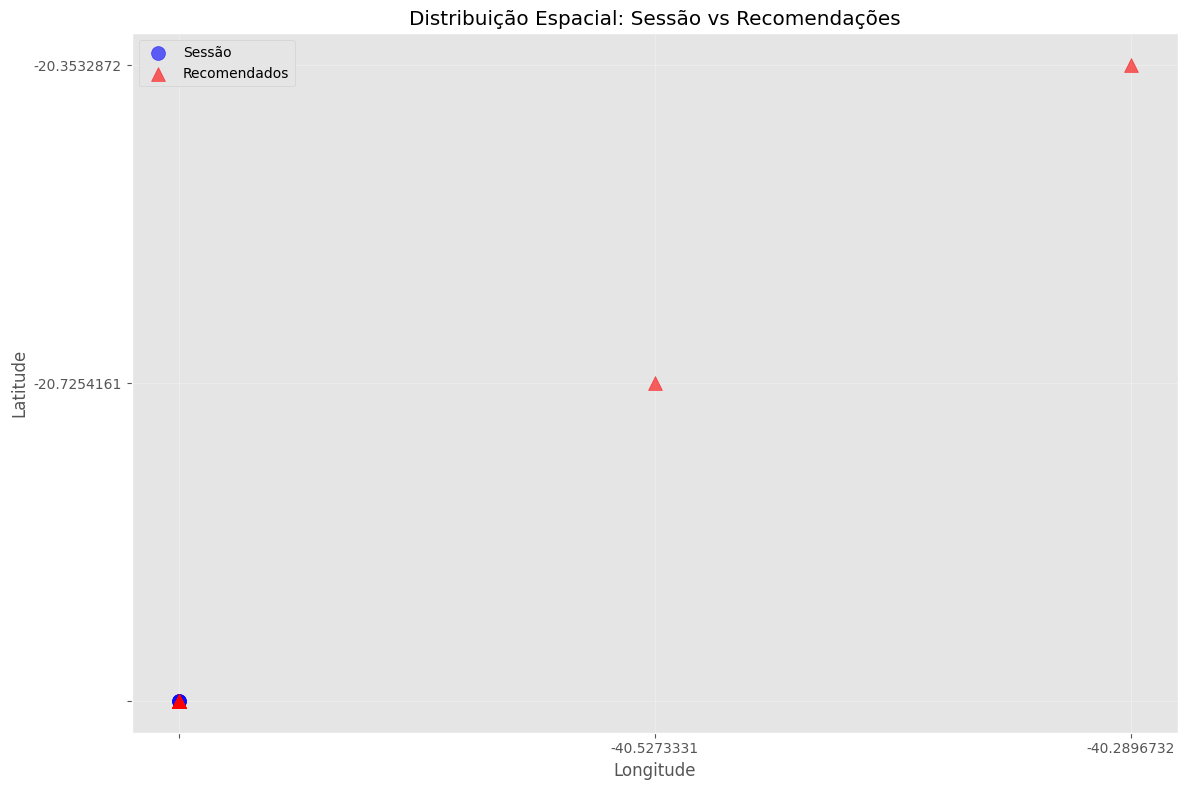


✓ Mapa gerado com sucesso!

Interpretação:
  - Pontos AZUIS: Anúncios da sessão (o que o usuário viu)
  - Pontos VERMELHOS: Recomendações (o que o modelo sugere)

O ideal é que os pontos vermelhos estejam próximos dos azuis.


In [33]:
# Visualizar distribuição geográfica
try:
    print("Gerando mapa...\n")
    explorer.visualize_spatial_distribution(session_items, top_k=10)
    print("\n✓ Mapa gerado com sucesso!")
    print("\nInterpretação:")
    print("  - Pontos AZUIS: Anúncios da sessão (o que o usuário viu)")
    print("  - Pontos VERMELHOS: Recomendações (o que o modelo sugere)")
    print("\nO ideal é que os pontos vermelhos estejam próximos dos azuis.")
except Exception as e:
    print(f"⚠️  Visualização espacial não disponível: {e}")
    print("    Possíveis causas:")
    print("    - Dados sem latitude/longitude")
    print("    - Valores vazios nas coordenadas")

## 9. Análise de Múltiplas Sessões

Para validar melhor o modelo, teste com **várias sessões diferentes**.

### Por que testar múltiplas sessões?
- Verificar **consistência**: Modelo se comporta bem em diferentes casos?
- Detectar **vieses**: Modelo sempre recomenda os mesmos tipos?
- Validar **generalização**: Funciona para perfis diferentes?

### Tipos de sessões para testar:
1. **Sessão de luxo**: Anúncios caros (>R$ 1M)
2. **Sessão econômica**: Anúncios baratos (<R$ 300k)
3. **Sessão regional**: Todos da mesma cidade
4. **Sessão mista**: Anúncios variados

### O que observar?
- Modelo recomenda preços compatíveis em cada caso?
- Mantém coerência geográfica?
- Adapta-se ao perfil da sessão?

In [34]:
# Definir várias sessões de teste
# AJUSTE: Crie sessões que representem diferentes perfis de usuário
test_sessions = [
    {'name': 'Sessão 1', 'ids': [100, 200, 300]},
    {'name': 'Sessão 2', 'ids': [150, 250, 350]},
    {'name': 'Sessão 3', 'ids': [180, 280, 380]},
]

print(f"Testando {len(test_sessions)} sessões diferentes...\n")

for i, session in enumerate(test_sessions, 1):
    print("\n" + "="*100)
    print(f" {session['name'].upper()}")
    print("="*100)
    
    try:
        # Gerar apenas top-5 para não poluir
        recs = explorer.recommend_for_session(session['ids'], top_k=5)
        print(f"\nSessão: {session['ids']}")
        print(f"Top-5 recomendações: {recs}")
        
        # Comparação rápida
        if explorer.item_features is not None:
            sess_df = explorer.item_features[explorer.item_features['listing_id'].isin(session['ids'])]
            rec_df = explorer.item_features[explorer.item_features['listing_id'].isin(recs)]
            
            if len(sess_df) > 0 and len(rec_df) > 0:
                print("\nComparação:")
                
                if 'price' in sess_df.columns:
                    sess_price = sess_df['price'].mean()
                    rec_price = rec_df['price'].mean()
                    print(f"  Preço médio sessão: R$ {sess_price:,.0f}")
                    print(f"  Preço médio recomendações: R$ {rec_price:,.0f}")
                    print(f"  Diferença: {((rec_price - sess_price) / sess_price * 100):+.1f}%")
                
                if 'city' in sess_df.columns:
                    sess_cities = set(sess_df['city'].dropna())
                    rec_cities = set(rec_df['city'].dropna())
                    overlap = sess_cities & rec_cities
                    print(f"\n  Cidades sessão: {sess_cities}")
                    print(f"  Cidades recomendações: {rec_cities}")
                    if len(overlap) > 0:
                        print(f"  ✓ Overlap: {overlap}")
    
    except Exception as e:
        print(f"✗ Erro: {e}")

print("\n" + "="*100)
print("\n✓ Análise de múltiplas sessões concluída!")
print("\nO que observar:")
print("  - O modelo se adapta a diferentes perfis?")
print("  - Há consistência nas recomendações?")
print("  - Algum viés óbvio (sempre recomenda mesma região/preço)?")

Testando 3 sessões diferentes...


 SESSÃO 1

Sessão: [100, 200, 300]
Top-5 recomendações: [18769, 8762, 3161, 8451, 8682]

Comparação:
  Preço médio sessão: R$ 2,729,101
  Preço médio recomendações: R$ 965,000
  Diferença: -64.6%

  Cidades sessão: {'Vila Velha', 'Vitória'}
  Cidades recomendações: {'Guarapari', 'Vila Velha'}
  ✓ Overlap: {'Vila Velha'}

 SESSÃO 2

Sessão: [150, 250, 350]
Top-5 recomendações: [18769, 8762, 3161, 8451, 8682]

Comparação:
  Preço médio sessão: R$ 505,000
  Preço médio recomendações: R$ 965,000
  Diferença: +91.1%

  Cidades sessão: {'Vila Velha', 'Serra'}
  Cidades recomendações: {'Guarapari', 'Vila Velha'}
  ✓ Overlap: {'Vila Velha'}

 SESSÃO 3

Sessão: [180, 280, 380]
Top-5 recomendações: [18769, 8762, 3161, 8451, 8682]

Comparação:
  Preço médio sessão: R$ 673,333
  Preço médio recomendações: R$ 965,000
  Diferença: +43.3%

  Cidades sessão: {'Guarapari', 'Vitória'}
  Cidades recomendações: {'Guarapari', 'Vila Velha'}
  ✓ Overlap: {'Guarapari'}


✓ A

## 10. Análise Visual: Distribuições

Visualizações ajudam a identificar padrões que números não mostram.

### Gráficos gerados:

**1. Histograma de Preços**
- Compara distribuição de preços (sessão vs recomendações)
- **Ideal**: Distribuições sobrepostas ou próximas
- **Problema**: Distribuições muito diferentes (modelo não captou preferência de preço)

**2. Boxplot de Áreas**
- Mostra mediana, quartis e outliers
- **Ideal**: Medianas próximas, ranges similares
- **Problema**: Recomendações muito maiores/menores que sessão

### Como interpretar?

**Sobreposição alta** → Modelo capturou bem as preferências
**Sobreposição baixa** → Modelo pode estar recomendando aleatoriamente
**Recomendações muito uniformes** → Modelo pode ter viés (sempre recomenda mesmo tipo)

/tmp/ipykernel_928050/3308155250.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(data_to_plot, labels=['Sessão', 'Recomendações'],


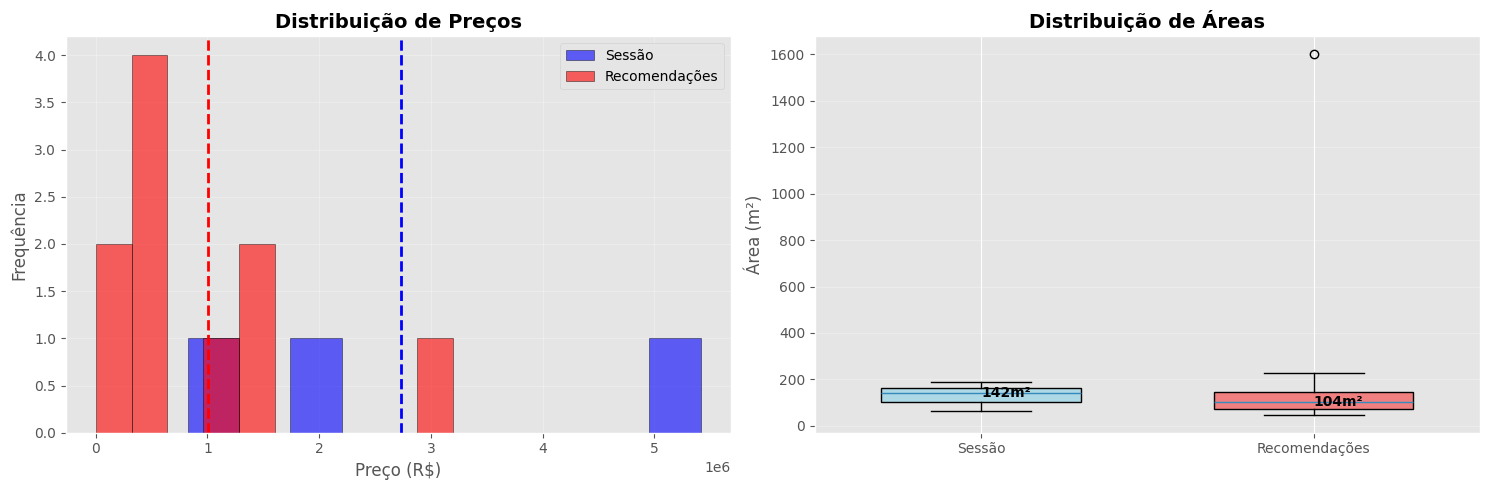


 ANÁLISE DAS DISTRIBUIÇÕES

📊 PREÇOS:
  Sessão: média=R$ 2,729,101, mediana=R$ 1,950,000
  Recomendações: média=R$ 1,000,685, mediana=R$ 610,000
  ✗ Diferença: -63.3% - GRANDE! Modelo pode não estar capturando preferência de preço.

📐 ÁREAS:
  Sessão: mediana=142m²
  Recomendações: mediana=104m²
  ⚠ Diferença: -26.8% - Tamanhos diferentes



In [35]:
# Análise visual de distribuições
session_df = explorer.item_features[explorer.item_features['listing_id'].isin(session_items)]
rec_ids = explorer.recommend_for_session(session_items, top_k=10)
rec_df = explorer.item_features[explorer.item_features['listing_id'].isin(rec_ids)]

if len(session_df) > 0 and len(rec_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 1. Histograma de preços
    if 'price' in rec_df.columns:
        sess_prices = session_df['price'].dropna()
        rec_prices = rec_df['price'].dropna()
        
        if len(sess_prices) > 0 and len(rec_prices) > 0:
            axes[0].hist(sess_prices, bins=10, alpha=0.6, label='Sessão', color='blue', edgecolor='black')
            axes[0].hist(rec_prices, bins=10, alpha=0.6, label='Recomendações', color='red', edgecolor='black')
            axes[0].set_xlabel('Preço (R$)', fontsize=12)
            axes[0].set_ylabel('Frequência', fontsize=12)
            axes[0].set_title('Distribuição de Preços', fontsize=14, fontweight='bold')
            axes[0].legend(fontsize=10)
            axes[0].grid(True, alpha=0.3)
            
            # Adicionar estatísticas
            sess_mean = sess_prices.mean()
            rec_mean = rec_prices.mean()
            axes[0].axvline(sess_mean, color='blue', linestyle='--', linewidth=2, label=f'Média sessão: {sess_mean:,.0f}')
            axes[0].axvline(rec_mean, color='red', linestyle='--', linewidth=2, label=f'Média recs: {rec_mean:,.0f}')
    
    # 2. Boxplot de áreas
    area_col = 'usable_areas' if 'usable_areas' in rec_df.columns else 'total_areas'
    if area_col in rec_df.columns:
        sess_areas = session_df[area_col].dropna()
        rec_areas = rec_df[area_col].dropna()
        
        if len(sess_areas) > 0 and len(rec_areas) > 0:
            data_to_plot = [sess_areas, rec_areas]
            bp = axes[1].boxplot(data_to_plot, labels=['Sessão', 'Recomendações'],
                                patch_artist=True, widths=0.6)
            
            # Colorir boxes
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('lightcoral')
            
            axes[1].set_ylabel('Área (m²)', fontsize=12)
            axes[1].set_title('Distribuição de Áreas', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3, axis='y')
            
            # Adicionar valores
            sess_median = sess_areas.median()
            rec_median = rec_areas.median()
            axes[1].text(1, sess_median, f'{sess_median:.0f}m²', 
                        ha='left', va='center', fontweight='bold')
            axes[1].text(2, rec_median, f'{rec_median:.0f}m²', 
                        ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Análise textual
    print("\n" + "="*100)
    print(" ANÁLISE DAS DISTRIBUIÇÕES")
    print("="*100)
    
    if 'price' in rec_df.columns:
        print("\n📊 PREÇOS:")
        print(f"  Sessão: média=R$ {sess_prices.mean():,.0f}, mediana=R$ {sess_prices.median():,.0f}")
        print(f"  Recomendações: média=R$ {rec_prices.mean():,.0f}, mediana=R$ {rec_prices.median():,.0f}")
        
        diff = ((rec_prices.mean() - sess_prices.mean()) / sess_prices.mean()) * 100
        if abs(diff) < 20:
            print(f"  ✓ Diferença: {diff:+.1f}% - ÓTIMO! Preços similares.")
        elif abs(diff) < 50:
            print(f"  ⚠ Diferença: {diff:+.1f}% - MODERADO. Recomendações um pouco diferentes.")
        else:
            print(f"  ✗ Diferença: {diff:+.1f}% - GRANDE! Modelo pode não estar capturando preferência de preço.")
    
    if area_col in rec_df.columns:
        print("\n📐 ÁREAS:")
        print(f"  Sessão: mediana={sess_areas.median():.0f}m²")
        print(f"  Recomendações: mediana={rec_areas.median():.0f}m²")
        
        diff = ((rec_areas.median() - sess_areas.median()) / sess_areas.median()) * 100
        if abs(diff) < 20:
            print(f"  ✓ Diferença: {diff:+.1f}% - SIMILAR")
        else:
            print(f"  ⚠ Diferença: {diff:+.1f}% - Tamanhos diferentes")
    
    print("\n" + "="*100)
else:
    print("⚠️  Dados insuficientes para visualização")

## 11. Conclusões e Próximos Passos

### Como avaliar se o modelo é bom?

✅ **Modelo BOM** se:
1. Recomendações têm características similares à sessão
2. Preços e áreas estão na mesma faixa
3. Localização geográfica é coerente
4. Tipo de imóvel é compatível
5. Adapta-se a diferentes perfis de sessão

❌ **Modelo RUIM** se:
1. Recomenda imóveis muito diferentes (preço, tamanho, localização)
2. Sempre recomenda os mesmos itens (falta personalização)
3. Não captura preferências implícitas
4. Comportamento inconsistente entre sessões

### Próximos passos:

1. **Se modelo está bom:**
   - Teste com mais sessões reais
   - Valide com stakeholders de negócio
   - Considere deploy em produção (A/B test)

2. **Se modelo está ruim:**
   - Revise hiperparâmetros (learning rate, embedding size, etc.)
   - Teste outros modelos (NARM, SASRec, etc.)
   - Verifique qualidade dos dados de treino
   - Considere features adicionais (preço, localização, etc.)

3. **Análises adicionais:**
   - Diversidade das recomendações (Gini, ILS)
   - Novidade (recomenda itens recentes?)
   - Popularidade vs personalização
   - Análise por segmento (luxo vs econômico)

### Métricas Quantitativas vs Qualitativas

| Métrica | O que mede | Como validar |
|---------|------------|-------------|
| Recall@10 | Acerto no top-10 | Experimentos (dados históricos) |
| MRR | Posição do item certo | Experimentos (dados históricos) |
| Similaridade | Recomendações coerentes | **Esta análise exploratória** |
| Relevância | Fazem sentido? | **Validação com usuários** |

Ambas são importantes! Métricas numéricas mostram **se o modelo funciona**.
Análise exploratória mostra **como ele funciona** e **se faz sentido de negócio**.

In [ ]:
print("="*100)
print(" RESUMO DA ANÁLISE")
print("="*100)

print(f"\n✓ Modelo analisado: {model_path}")
print(f"✓ Sessões testadas: {len(test_sessions) if 'test_sessions' in locals() else 1}")
print(f"✓ Recomendações geradas: Top-10")

print("\n" + "="*100)
print(" CHECKLIST DE VALIDAÇÃO")
print("="*100)

print("\n[ ] As recomendações têm preços similares à sessão?")
print("[ ] As recomendações são da mesma região geográfica?")
print("[ ] O número de quartos/tamanho é compatível?")
print("[ ] O tipo de imóvel faz sentido?")
print("[ ] O modelo se adapta a diferentes perfis?")
print("[ ] Há diversidade nas recomendações ou sempre os mesmos?")

print("\n" + "="*100)
print("\nPróximos passos:")
print("  1. Revisar respostas do checklist acima")
print("  2. Se necessário, ajustar hiperparâmetros e retreinar")
print("  3. Validar com mais sessões de teste")
print("  4. Apresentar resultados para stakeholders")
print("\n" + "="*100)